In [1]:
cd ~/work/repos/modl/examples/contrast/

/storage/store/work/amensch/work/repos/modl/examples/contrast


In [2]:
ls

analysis/                    predict_contrast_new.py  prepare.py
Multiclass tensorflow.ipynb  predict_contrast.py      __pycache__/
multi_predict_contrast.py    prediction.csv           reduce_contrast.py


In [3]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [4]:
%matplotlib inline

def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [21]:
(np.mean(np.abs(G), axis=1) - 1 / G.shape[1] ) * (G.shape[1] / (G.shape[1] - 1))

array([ 0.15818949,  0.13096717,  0.15181953,  0.13736863,  0.12438457,
        0.12788478,  0.1390084 ,  0.15977478,  0.13475066,  0.16519159,
        0.14322956,  0.14418644,  0.12997718,  0.14648309,  0.16054577,
        0.12780768,  0.12257423,  0.14556885,  0.15315013,  0.11644936,
        0.17522956,  0.15574688,  0.16211933,  0.14013633,  0.14936616,
        0.12227187,  0.14737277,  0.1539904 ,  0.11515826,  0.11792964,
        0.13792683,  0.16192882,  0.1605365 ,  0.11606205,  0.11594707,
        0.14603829,  0.13924789,  0.16111203,  0.1320726 ,  0.13686678,
        0.14417259,  0.16572899,  0.16669771,  0.15510674,  0.15729804,
        0.12713458,  0.14993072,  0.16121125,  0.16259445,  0.16047724,
        0.15217939,  0.14376158,  0.14989033,  0.14424822,  0.16443747,
        0.13461198,  0.14736001,  0.14841825,  0.14161617,  0.14806794,
        0.14591318,  0.15310781,  0.15377007,  0.16937238,  0.13679987,
        0.1342161 ,  0.15903461,  0.16606067,  0.11365917,  0.12

In [23]:
from modl.fixes import Model
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

In [ ]:
model = estimator.steps[-1][1].stacked_model_

supervised_layers =  model.layers_by_depth[2]
embedding_layer =  model.layers_by_depth[3][0]

w0 = []
for layer in supervised_layers:
    this_w0, this_b0 = layer.get_weights()
    w0.append(this_w0)
w0 = np.concatenate(w0, axis=1)
w1 = embedding_layer.get_weights()[0]

coef = w1.dot(w0).T

print('Sparsity', (coef == 0).sum() / coef.size)

In [26]:
prediction = prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'])

In [27]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [36]:
labels = prediction.index.get_level_values('contrast').unique()

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

In [39]:
labels

Index(['expression_control', 'expression_intention', 'expression_sex',
       'face_control', 'face_sex', 'face_trusty', 'audio', 'calculaudio',
       'calculvideo', 'clicDaudio', 'clicDvideo', 'clicGaudio', 'clicGvideo',
       'computation', 'damier_H', 'damier_V', 'motor-cognitive',
       'object_grasp', 'object_orientation', 'rotation_hand', 'rotation_side',
       'saccade', 'false_belief_audio', 'false_belief_video',
       'mecanistic_audio', 'mecanistic_video', 'non_speech', 'speech',
       'triangle_intention', 'triangle_random', 'FACES', 'SHAPES', 'PUNISH',
       'REWARD', 'MATH', 'STORY', 'CUE', 'LF', 'LH', 'RF', 'RH', 'MATCH',
       'REL', 'RANDOM', 'TOM', '0BK_BODY', '0BK_FACE', '0BK_PLACE', '0BK_TOOL',
       '2BK_BODY', '2BK_FACE', '2BK_PLACE', '2BK_TOOL', 'BALOON_ACCEPT',
       'BALOON_CASHOUT', 'BALOON_EXPLODE', 'CONTROL_ACCEPT', 'HOLD_ONS',
       'PREP_ONS', 'REST_ONS', 'CORRECT', 'INCORRECT', 'BLANKSCREEN',
       'GO_LEFT', 'GO_RIGHT', 'STOP_LEFT', 'STOP_RIGH

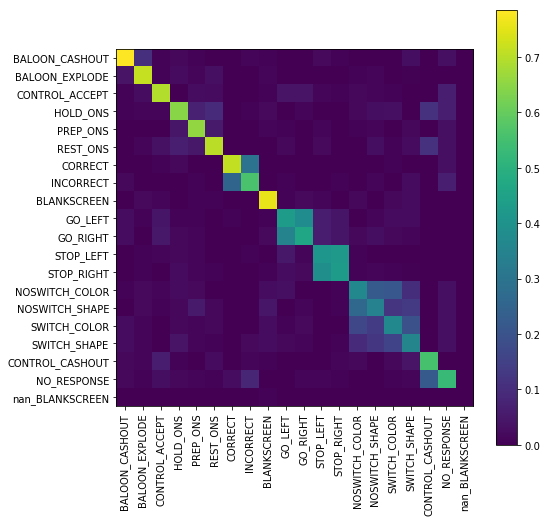

In [42]:
plot_confusion_matrix(test_conf[-20:, -20:], labels[-20:])

In [41]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task        contrast            
archi    emotional   expression_control      0.692308
                     expression_intention    0.923077
                     expression_sex          0.615385
                     face_control            0.487179
                     face_sex                0.743590
                     face_trusty             0.794872
         localizer   audio                   0.897436
                     calculaudio             0.923077
                     calculvideo             0.871795
                     clicDaudio              0.948718
                     clicDvideo              0.948718
                     clicGaudio              1.000000
                     clicGvideo              0.948718
                     computation             0.846154
                     damier_H                0.948718
                     damier_V                0.974359
                     motor-cognitive         1.000000
         parietal    object_grasp       

In [ ]:
idx = pd.IndexSlice
prediction.loc[idx['test']]

In [43]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.852991
       hcp        0.891029
       la5c       0.557812
train  archi      0.993162
       hcp        0.916508
       la5c       0.748754
Name: match, dtype: float64

In [ ]:
classifier = estimator.named_steps['classifier']

In [ ]:
histories = classifier.histories_

In [ ]:
history.epoch

In [ ]:
for history, n_samples in zip(histories, classifier.n_samples_):
    plt.plot(np.array(history.epoch) * n_samples, history.history['val_acc'])

In [ ]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [ ]:
np.mean(w0 == 0),np.mean(w1 == 0)

In [ ]:
np.histogram(w1)

In [ ]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)